<a href="https://colab.research.google.com/github/NguyenPhuongDng/Stock-Price-Prediction/blob/main/Stock_predict_LSTM_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math


# Lấy dữ liệu
try:
    df = pd.read_csv("fpt_lsg.csv")
    df = df.reset_index()[:1500] # Chuyển cột Date thành cột thông thường
    df = df[['Ngày', 'Giá đóng cửa']]
    # Kiểm tra và xử lý dữ liệu thiếu nếu có
    df = df.dropna()
    print(df)
    if df.empty:
        raise ValueError("Không tải được dữ liệu hoặc dữ liệu rỗng sau khi xử lý.")
    print("Đã tải dữ liệu thành công.")
    print(df.head())
except Exception as e:
    print(f"Lỗi khi tải dữ liệu: {e}")
    exit() # Thoát nếu không có dữ liệu

# Giữ lại các cột cần thiết và chuẩn bị cho Prophet
df_prophet = df[['Ngày', 'Giá đóng cửa']].copy()
df_prophet.rename(columns={'Ngày': 'ds', 'Giá đóng cửa': 'y'}, inplace=True)

# *** FIX 1: Sắp xếp dữ liệu theo ngày tăng dần và reset index ***
# Đây là bước CỰC KỲ QUAN TRỌNG để Prophet hiểu đúng trình tự thời gian
df_prophet = df_prophet.sort_values(by='ds', ascending=True).reset_index(drop=True)

print("\nDữ liệu sau khi định dạng cho Prophet:")
print(df_prophet.head())

            Ngày  Giá đóng cửa
0     2025-05-08        114.30
1     2025-05-07        109.70
2     2025-05-06        109.70
3     2025-05-05        108.60
4     2025-04-29        109.40
...          ...           ...
1495  2019-05-13         49.50
1496  2019-05-10         49.00
1497  2019-05-09         48.60
1498  2019-05-08         49.65
1499  2019-05-07         49.70

[1500 rows x 2 columns]
Đã tải dữ liệu thành công.
         Ngày  Giá đóng cửa
0  2025-05-08         114.3
1  2025-05-07         109.7
2  2025-05-06         109.7
3  2025-05-05         108.6
4  2025-04-29         109.4

Dữ liệu sau khi định dạng cho Prophet:
           ds      y
0  2019-05-07  49.70
1  2019-05-08  49.65
2  2019-05-09  48.60
3  2019-05-10  49.00
4  2019-05-13  49.50


In [ ]:
# Số ngày muốn dự báo trong tương lai
future_days = 500

# Sử dụng toàn bộ dữ liệu lịch sử cho Prophet training
df_train_prophet = df_prophet.copy()[:-10]




In [ ]:
!pip install ta

In [ ]:
# Khởi tạo model với các mùa vụ bạn muốn (ví dụ: yearly, daily)
m = Prophet(
    yearly_seasonality=True,  # Có mùa vụ hàng năm
    weekly_seasonality=False, # Không dùng mùa vụ hàng tuần
    daily_seasonality=False    # Có mùa vụ hàng ngày (nếu dữ liệu của bạn đủ chi tiết)
)

# *** Thêm mùa vụ theo tháng ***
# period = 30.5 ngày (hoặc 365.25 / 12)
# fourier_order: Số lượng thành phần Fourier. Giá trị lớn hơn cho phép học các mẫu phức tạp hơn.
# Thường dùng giá trị từ 5 đến 15 cho mùa vụ theo tháng.
m.add_seasonality(name='monthly', period=90, fourier_order=20) # Ví dụ dùng fourier_order=10

m.fit(df_train_prophet)

# Tạo dataframe cho các ngày tương lai cần dự báo
future = m.make_future_dataframe(periods=future_days)

# Dự báo
forecast = m.predict(future)

print("\nDự báo của Prophet (một phần):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Lấy phần dự báo của Prophet trên dữ liệu training ban đầu để tính residuals
prophet_train_pred = forecast.iloc[:len(df_train_prophet)].copy()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpax3b0z03/ad01cwut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpax3b0z03/frnptejo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14088', 'data', 'file=/tmp/tmpax3b0z03/ad01cwut.json', 'init=/tmp/tmpax3b0z03/frnptejo.json', 'output', 'file=/tmp/tmpax3b0z03/prophet_modeldjw81jye/prophet_model-20250511092611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:26:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Dự báo của Prophet (một phần):
             ds        yhat  yhat_lower  yhat_upper
1985 2026-08-30  197.795915  153.601010  237.440660
1986 2026-08-31  198.119198  154.972681  237.269168
1987 2026-09-01  198.733740  154.988039  238.155685
1988 2026-09-02  199.185343  157.288815  239.187642
1989 2026-09-03  199.038260  154.966442  239.225642


In [ ]:
# # Khởi tạo và huấn luyện mô hình Prophet
# m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=True)
# m.fit(df_train_prophet)

# # Tạo dataframe cho các ngày tương lai cần dự báo
# future = m.make_future_dataframe(periods=future_days)

# # Dự báo
# forecast = m.predict(future)

# print("\nDự báo của Prophet (một phần):")
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# # Lấy phần dự báo của Prophet trên dữ liệu training ban đầu để tính residuals
# prophet_train_pred = forecast.iloc[:len(df_train_prophet)].copy()

In [ ]:
df_train_prophet

,ds,y
0,2019-05-07,49.70
1,2019-05-08,49.65
2,2019-05-09,48.60
3,2019-05-10,49.00
4,2019-05-13,49.50
...,...,...
1485,2025-04-15,116.00
1486,2025-04-16,107.90
1487,2025-04-17,109.40
1488,2025-04-18,111.60


In [ ]:
prophet_train_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-05-07,40.462706,39.978317,55.368283,40.462706,40.462706,7.045126,7.045126,7.045126,0.893894,0.893894,0.893894,6.151233,6.151233,6.151233,0.0,0.0,0.0,47.507833
1,2019-05-08,40.556961,41.588445,56.239053,40.556961,40.556961,8.169288,8.169288,8.169288,1.764078,1.764078,1.764078,6.405210,6.405210,6.405210,0.0,0.0,0.0,48.726249
2,2019-05-09,40.651216,41.306483,56.837925,40.651216,40.651216,8.073954,8.073954,8.073954,1.429822,1.429822,1.429822,6.644132,6.644132,6.644132,0.0,0.0,0.0,48.725170
3,2019-05-10,40.745471,39.985738,54.794055,40.745471,40.745471,6.640308,6.640308,6.640308,-0.229190,-0.229190,-0.229190,6.869497,6.869497,6.869497,0.0,0.0,0.0,47.385779
4,2019-05-13,41.028236,38.814299,54.375701,41.028236,41.028236,5.217344,5.217344,5.217344,-2.260318,-2.260318,-2.260318,7.477663,7.477663,7.477663,0.0,0.0,0.0,46.245580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,2025-04-15,148.341209,136.336732,151.462268,148.341209,148.341209,-4.954380,-4.954380,-4.954380,-1.630918,-1.630918,-1.630918,-3.323462,-3.323462,-3.323462,0.0,0.0,0.0,143.386829
1486,2025-04-16,148.428868,135.195419,150.538057,148.428868,148.428868,-6.030140,-6.030140,-6.030140,-3.190615,-3.190615,-3.190615,-2.839525,-2.839525,-2.839525,0.0,0.0,0.0,142.398729
1487,2025-04-17,148.516527,134.165833,149.670137,148.516527,148.516527,-6.486372,-6.486372,-6.486372,-4.147768,-4.147768,-4.147768,-2.338603,-2.338603,-2.338603,0.0,0.0,0.0,142.030156
1488,2025-04-18,148.604187,135.849345,150.890139,148.604187,148.604187,-5.679938,-5.679938,-5.679938,-3.855372,-3.855372,-3.855372,-1.824566,-1.824566,-1.824566,0.0,0.0,0.0,142.924249


In [ ]:
# Tính Residuals = Actual - Prophet_Predicted trên tập training
residuals = df_train_prophet['y'] - prophet_train_pred['yhat']
print("\nResiduals (một phần):")
print(residuals.head())
print(residuals.tail())

# Chuyển residuals sang DataFrame để dễ xử lý
residuals_df = pd.DataFrame(residuals, columns=['residual'])


Residuals (một phần):
0    2.192167
1    0.923751
2   -0.125170
3    1.614221
4    3.254420
dtype: float64
1485   -27.386829
1486   -34.498729
1487   -32.630156
1488   -31.324249
1489   -36.221345
dtype: float64


In [ ]:
# Scale Residuals
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals_df)

print("\nScaled Residuals (một phần):")
print(scaled_residuals[:5])

# Hàm tạo sequence cho LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length), 0]
        label = data[i + seq_length, 0]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

# Chiều dài của sequence (lookback window) - cần tinh chỉnh
seq_length = 60 # Ví dụ: sử dụng 60 ngày residuals trước để dự đoán ngày tiếp theo

X_res, y_res = create_sequences(scaled_residuals, seq_length)

# Reshape input cho LSTM [samples, time steps, features]
X_res = np.reshape(X_res, (X_res.shape[0], X_res.shape[1], 1))

print(f"\nShape của dữ liệu input cho LSTM (X_res): {X_res.shape}")
print(f"Shape của dữ liệu output cho LSTM (y_res): {y_res.shape}")


Scaled Residuals (một phần):
[[0.66646145]
 [0.64457661]
 [0.62647889]
 [0.65648976]
 [0.6847892 ]]

Shape của dữ liệu input cho LSTM (X_res): (1430, 60, 1)
Shape của dữ liệu output cho LSTM (y_res): (1430,)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2045
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0093
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0078
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0080
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0073
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0068
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0064
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0067
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0064
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0070
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053
Epoch 16/50
45/45 ━━

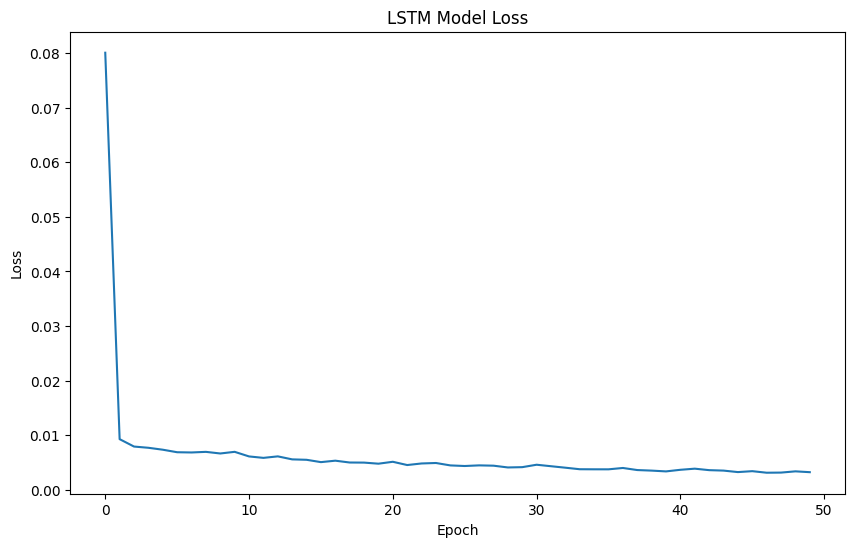

In [ ]:
# Xây dựng mô hình LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1)) # Output 1 giá trị: residual tiếp theo

# Compile mô hình
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình LSTM
# Cân nhắc sử dụng tập validation nếu dữ liệu lớn
history = model_lstm.fit(X_res, y_res, epochs=50, batch_size=32) # Số epochs và batch size cần tinh chỉnh

print("\nĐã huấn luyện xong mô hình LSTM.")

# (Tùy chọn) Vẽ biểu đồ loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Chuẩn bị dữ liệu input cho dự báo residuals tương lai
# Lấy N ngày residuals cuối cùng từ tập training làm input ban đầu
last_seq = scaled_residuals[-seq_length:].reshape(1, seq_length, 1)
predicted_scaled_residuals = []

# Dự báo residuals cho future_days ngày tới
for _ in range(future_days):
    # Dự báo bước tiếp theo
    next_residual = model_lstm.predict(last_seq)
    predicted_scaled_residuals.append(next_residual[0, 0])

    # Cập nhật chuỗi input: loại bỏ giá trị cũ nhất, thêm giá trị dự báo mới nhất
    next_seq = np.append(last_seq[:, 1:, :], next_residual.reshape(1, 1, 1), axis=1)
    last_seq = next_seq

# Chuyển scaled residuals dự báo về lại scale ban đầu
predicted_residuals = scaler.inverse_transform(np.array(predicted_scaled_residuals).reshape(-1, 1))

print(f"\nĐã dự báo {future_days} ngày residuals bằng LSTM.")
print("Predicted Residuals (một phần):")
print(predicted_residuals[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

In [ ]:
# Lấy phần dự báo Prophet cho future_days ngày tới
prophet_future_pred = forecast[['ds', 'yhat']].tail(future_days).reset_index(drop=True)

# Thêm cột residuals dự báo từ LSTM
prophet_future_pred['residual_pred'] = predicted_residuals

# Kết hợp dự báo: Prophet_pred + LSTM_residual_pred
final_hybrid_pred = prophet_future_pred['yhat'] + prophet_future_pred['residual_pred']

# Tạo DataFrame kết quả cuối cùng
final_forecast_df = pd.DataFrame({
    'ds': prophet_future_pred['ds'],
    'Prophet_yhat': prophet_future_pred['yhat'],
    'LSTM_residual_pred': prophet_future_pred['residual_pred'],
    'Hybrid_yhat': final_hybrid_pred
})

print("\nKết quả dự báo Hybrid cuối cùng:")
print(final_forecast_df.head())
print(final_forecast_df.tail())


Kết quả dự báo Hybrid cuối cùng:
          ds  Prophet_yhat  LSTM_residual_pred  Hybrid_yhat
0 2025-04-22    147.719395          -33.686108   114.033287
1 2025-04-23    147.043148          -34.826504   112.216644
2 2025-04-24    146.762962          -35.856506   110.906455
3 2025-04-25    147.236113          -36.853188   110.382925
4 2025-04-26    148.321656          -37.857918   110.463738
            ds  Prophet_yhat  LSTM_residual_pred  Hybrid_yhat
495 2026-08-30    197.795915         -168.952332    28.843584
496 2026-08-31    198.119198         -168.952332    29.166867
497 2026-09-01    198.733740         -168.952332    29.781408
498 2026-09-02    199.185343         -168.952332    30.233012
499 2026-09-03    199.038260         -168.952332    30.085929


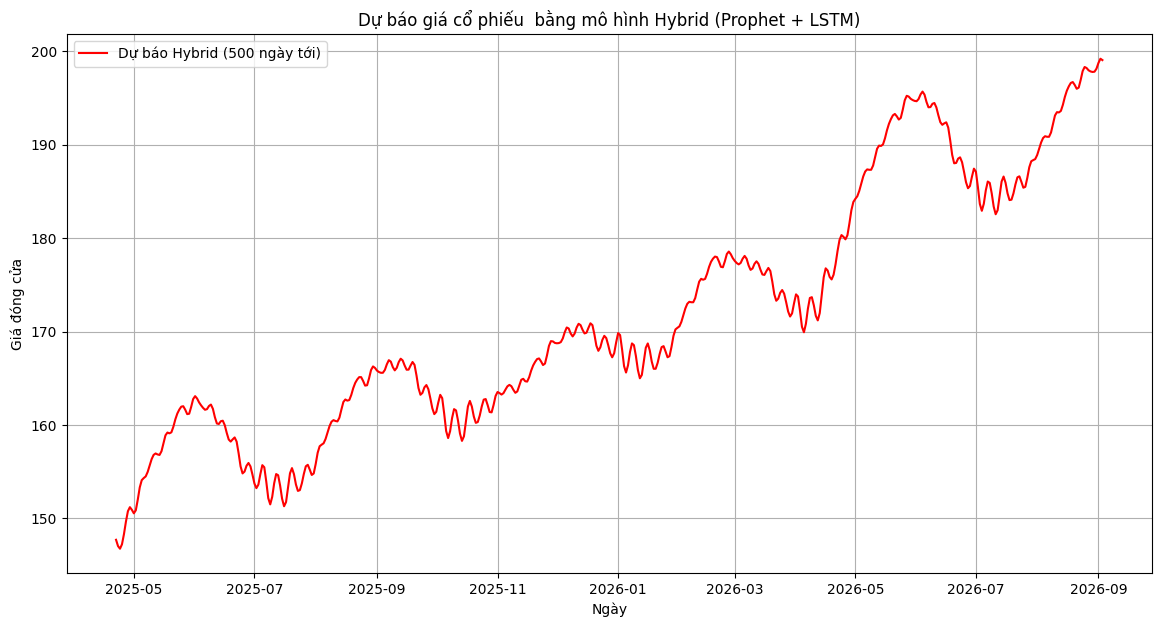

In [ ]:

# Kết hợp dự báo cuối cùng (ví dụ)
# final_forecast_df = pd.DataFrame({
#     'ds': ...,
#     'Hybrid_yhat': ...
# })

# === Đảm bảo cột 'ds' là kiểu datetime trước khi vẽ ===
final_forecast_df['ds'] = pd.to_datetime(final_forecast_df['ds'])

# (Tùy chọn nhưng nên làm) Đảm bảo cột 'ds' trong dữ liệu lịch sử cũng là datetime
if 'df_prophet' in locals(): # Kiểm tra xem df_prophet có tồn tại không
   df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# (Tùy chọn nhưng nên làm) Đảm bảo cột 'ds' trong forecast gốc cũng là datetime,
# đặc biệt nếu bạn dùng nó cho các đường khác như trend hoặc prophet yhat đầy đủ
# if 'forecast' in locals(): # Kiểm tra xem forecast có tồn tại không
#    forecast['ds'] = pd.to_datetime(forecast['ds'])
# Trực quan hóa kết quả
plt.figure(figsize=(14, 7))

# Vẽ dữ liệu lịch sử
# plt.plot(df_prophet['ds'], df_prophet['y'], label='Giá đóng cửa thực tế (Lịch sử)')

# Vẽ dự báo của Prophet (bao gồm cả trên dữ liệu lịch sử và tương lai)
# Cần kết hợp forecast trên training và future
# prophet_full_pred = forecast[['ds', 'yhat']].copy()
# plt.plot(prophet_full_pred['ds'], prophet_full_pred['yhat'], label='Dự báo Prophet (Toàn bộ)', linestyle='--') # Có thể gây rối nếu quá dài

# Vẽ dự báo Hybrid cho tương lai
plt.plot(final_forecast_df['ds'], final_forecast_df['Prophet_yhat'], label=f'Dự báo Hybrid ({future_days} ngày tới)', color='red')

# Vẽ dự báo Prophet cho tương lai (để so sánh)
# plt.plot(final_forecast_df['ds'], final_forecast_df['Prophet_yhat'], label=f'Dự báo Prophet ({future_days} ngày tới)', color='green', linestyle='-.')


plt.title(f'Dự báo giá cổ phiếu  bằng mô hình Hybrid (Prophet + LSTM)')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.show()


# (Tùy chọn) Đánh giá nếu có dữ liệu thực tế cho future_days
# Giả sử bạn có df_test chứa giá trị thực tế cho future_days
# if 'df_test' in locals():
#     actual_future_prices = df_test['Close'].values # Lấy giá trị thực tế từ tập test
#     hybrid_predictions = final_forecast_df['Hybrid_yhat'].values[:len(actual_future_prices)]
#
#     rmse = math.sqrt(mean_squared_error(actual_future_prices, hybrid_predictions))
#     mape = mean_absolute_percentage_error(actual_future_prices, hybrid_predictions) * 100
#
#     print(f"\nĐánh giá trên {len(actual_future_prices)} ngày test:")
#     print(f"RMSE (Hybrid): {rmse:.2f}")
#     print(f"MAPE (Hybrid): {mape:.2f}%")
# else:
#     print("\nKhông có dữ liệu thực tế tương lai để đánh giá.")

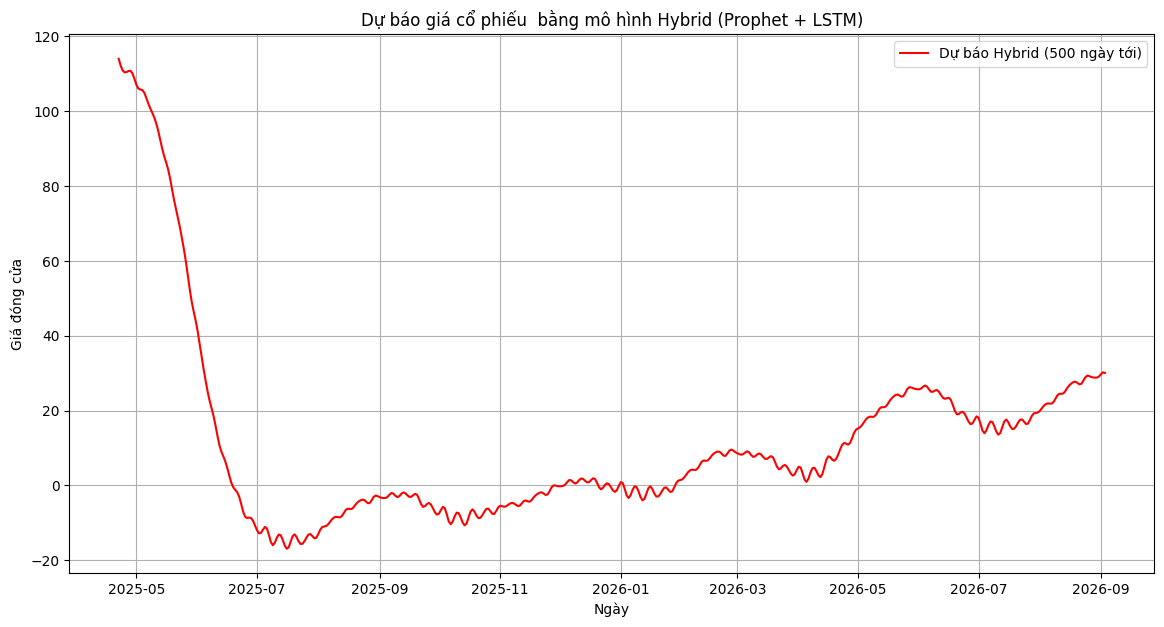

In [ ]:

# Kết hợp dự báo cuối cùng (ví dụ)
# final_forecast_df = pd.DataFrame({
#     'ds': ...,
#     'Hybrid_yhat': ...
# })

# === Đảm bảo cột 'ds' là kiểu datetime trước khi vẽ ===
final_forecast_df['ds'] = pd.to_datetime(final_forecast_df['ds'])

# (Tùy chọn nhưng nên làm) Đảm bảo cột 'ds' trong dữ liệu lịch sử cũng là datetime
if 'df_prophet' in locals(): # Kiểm tra xem df_prophet có tồn tại không
   df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# (Tùy chọn nhưng nên làm) Đảm bảo cột 'ds' trong forecast gốc cũng là datetime,
# đặc biệt nếu bạn dùng nó cho các đường khác như trend hoặc prophet yhat đầy đủ
# if 'forecast' in locals(): # Kiểm tra xem forecast có tồn tại không
#    forecast['ds'] = pd.to_datetime(forecast['ds'])
# Trực quan hóa kết quả
plt.figure(figsize=(14, 7))

# Vẽ dữ liệu lịch sử
# plt.plot(df_prophet['ds'], df_prophet['y'], label='Giá đóng cửa thực tế (Lịch sử)')

# Vẽ dự báo của Prophet (bao gồm cả trên dữ liệu lịch sử và tương lai)
# Cần kết hợp forecast trên training và future
# prophet_full_pred = forecast[['ds', 'yhat']].copy()
# plt.plot(prophet_full_pred['ds'], prophet_full_pred['yhat'], label='Dự báo Prophet (Toàn bộ)', linestyle='--') # Có thể gây rối nếu quá dài

# Vẽ dự báo Hybrid cho tương lai
plt.plot(final_forecast_df['ds'], final_forecast_df['Hybrid_yhat'], label=f'Dự báo Hybrid ({future_days} ngày tới)', color='red')

# Vẽ dự báo Prophet cho tương lai (để so sánh)
# plt.plot(final_forecast_df['ds'], final_forecast_df['Prophet_yhat'], label=f'Dự báo Prophet ({future_days} ngày tới)', color='green', linestyle='-.')


plt.title(f'Dự báo giá cổ phiếu  bằng mô hình Hybrid (Prophet + LSTM)')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.show()


# (Tùy chọn) Đánh giá nếu có dữ liệu thực tế cho future_days
# Giả sử bạn có df_test chứa giá trị thực tế cho future_days
# if 'df_test' in locals():
#     actual_future_prices = df_test['Close'].values # Lấy giá trị thực tế từ tập test
#     hybrid_predictions = final_forecast_df['Hybrid_yhat'].values[:len(actual_future_prices)]
#
#     rmse = math.sqrt(mean_squared_error(actual_future_prices, hybrid_predictions))
#     mape = mean_absolute_percentage_error(actual_future_prices, hybrid_predictions) * 100
#
#     print(f"\nĐánh giá trên {len(actual_future_prices)} ngày test:")
#     print(f"RMSE (Hybrid): {rmse:.2f}")
#     print(f"MAPE (Hybrid): {mape:.2f}%")
# else:
#     print("\nKhông có dữ liệu thực tế tương lai để đánh giá.")


Đã tính Trung bình trượt (30 ngày) cho dự báo Hybrid.
           ds  Prophet_yhat  LSTM_residual_pred  Hybrid_yhat  Hybrid_yhat_MA
0  2025-04-22    147.719395          -33.686108   114.033287             NaN
1  2025-04-23    147.043148          -34.826504   112.216644             NaN
2  2025-04-24    146.762962          -35.856506   110.906455             NaN
3  2025-04-25    147.236113          -36.853188   110.382925             NaN
4  2025-04-26    148.321656          -37.857918   110.463738             NaN
5  2025-04-27    149.660493          -38.893204   110.767289             NaN
6  2025-04-28    150.776144          -39.971756   110.804388             NaN
7  2025-04-29    151.208509          -41.101265   110.107244             NaN
8  2025-04-30    150.924432          -42.286873   108.637559             NaN
9  2025-05-01    150.550259          -43.532570   107.017689             NaN
10 2025-05-02    150.874516          -44.841812   106.032704             NaN
11 2025-05-03    152.

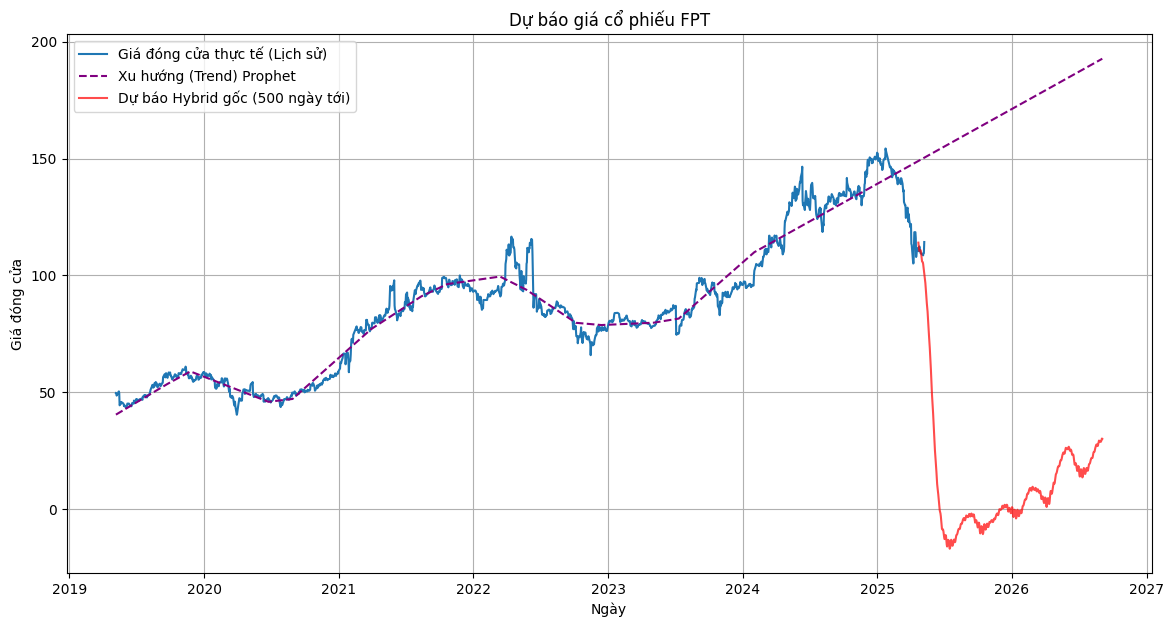

In [ ]:
# ... (các bước tạo final_forecast_df) ...

# Số ngày cho cửa sổ Trung bình trượt
# Chọn 7 nếu bạn muốn làm mượt tính thời vụ theo tuần
# Chọn số lớn hơn nếu muốn làm mượt nhiều hơn
window_size = 30

# Tính toán Trung bình trượt cho cột 'Hybrid_yhat'
# .rolling(window=window_size) tạo ra cửa sổ trượt
# .mean() tính trung bình trong mỗi cửa sổ
# .dropna() loại bỏ các giá trị NaN ở đầu (do không đủ dữ liệu trong cửa sổ ban đầu)
final_forecast_df['Hybrid_yhat_MA'] = final_forecast_df['Hybrid_yhat'].rolling(window=window_size).mean().dropna()

print(f"\nĐã tính Trung bình trượt ({window_size} ngày) cho dự báo Hybrid.")
print(final_forecast_df.head(window_size + 2)) # Xem vài dòng đầu để thấy MA bắt đầu sau NaNs
print(final_forecast_df.tail())


# ... (phần đảm bảo cột 'ds' là datetime) ...

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))

# Vẽ dữ liệu lịch sử (nếu có)
if 'df_prophet' in locals():
   plt.plot(df_prophet['ds'], df_prophet['y'], label='Giá đóng cửa thực tế (Lịch sử)')

# Vẽ đường Xu hướng (Trend) của Prophet (nếu muốn)
if 'forecast' in locals():
    plt.plot(forecast['ds'], forecast['trend'], label='Xu hướng (Trend) Prophet', color='purple', linestyle='--')


# Vẽ dự báo Hybrid gốc (đường "nhảy nhảy")
plt.plot(final_forecast_df['ds'], final_forecast_df['Hybrid_yhat'], label=f'Dự báo Hybrid gốc ({future_days} ngày tới)', color='red', alpha=0.7) # Giảm độ mờ để dễ nhìn hơn

# *** Vẽ đường Trung bình trượt của dự báo Hybrid ***
# Lấy dữ liệu từ dòng thứ window_size - 1 trở đi để loại bỏ NaN ở đầu
# plt.plot(final_forecast_df['ds'].iloc[window_size-1:], final_forecast_df['Hybrid_yhat_MA'].iloc[window_size-1:], label=f'Trung bình trượt Hybrid ({window_size} ngày)', color='darkorange')


# Vẽ dự báo Prophet cho tương lai (để so sánh)
# if 'forecast' in locals():
#     prophet_future_pred_plot = forecast[['ds', 'yhat']].tail(future_days).reset_index(drop=True)
#     prophet_future_pred_plot['ds'] = pd.to_datetime(prophet_future_pred_plot['ds'])
#     plt.plot(prophet_future_pred_plot['ds'], prophet_future_pred_plot['yhat'], label=f'Dự báo Prophet ({future_days} ngày tới)', color='green', linestyle='-.')


plt.title('Dự báo giá cổ phiếu FPT')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.show()